In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 5
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((522, 12, 1), (522,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT5/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 152ms/step - loss: 0.3138 - root_mean_squared_error: 0.5601 - val_loss: 0.2621 - val_root_mean_squared_error: 0.5119
Epoch 2/50
53/53 [==============================] - 8s 145ms/step - loss: 0.1846 - root_mean_squared_error: 0.4296 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2470
Epoch 3/50
53/53 [==============================] - 7s 136ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2349
Epoch 4/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2291
Epoch 5/50
53/53 [==============================] - 7s 136ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2152
Epoch 6/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0446 - root_mean_squared_error: 0.2113 - val_loss: 0.0381 - val

53/53 [==============================] - 7s 126ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 31/50
53/53 [==============================] - 7s 133ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 32/50
53/53 [==============================] - 7s 137ms/step - loss: 0.0130 - root_mean_squared_error: 0.1138 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 33/50
53/53 [==============================] - 7s 141ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 34/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 35/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0088 - val_root_me

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.280793309211731 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

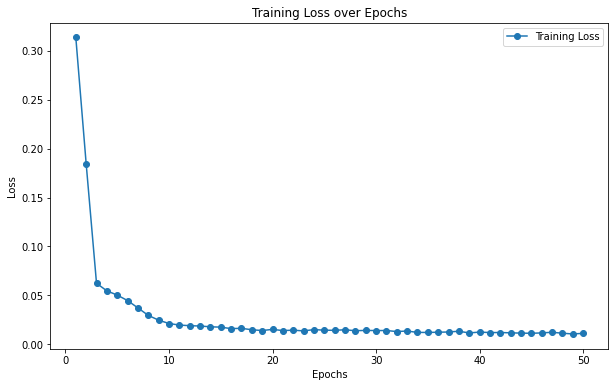

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

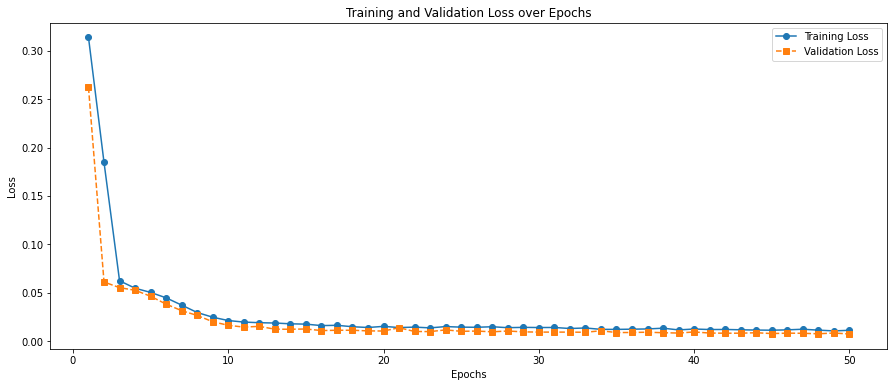

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT5/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09252614902082484
MAE : 0.07018009599402003


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5350337.000,6669726.076
1,5053284.500,6516136.854
2,4327542.500,5902163.675
3,3269030.000,3498103.449
4,2240209.500,1633675.726
5,1463210.000,1292668.399
6,1253902.125,1527666.815
7,2155666.250,2121949.701
8,3355884.250,3562381.775
9,4309795.500,5004305.983


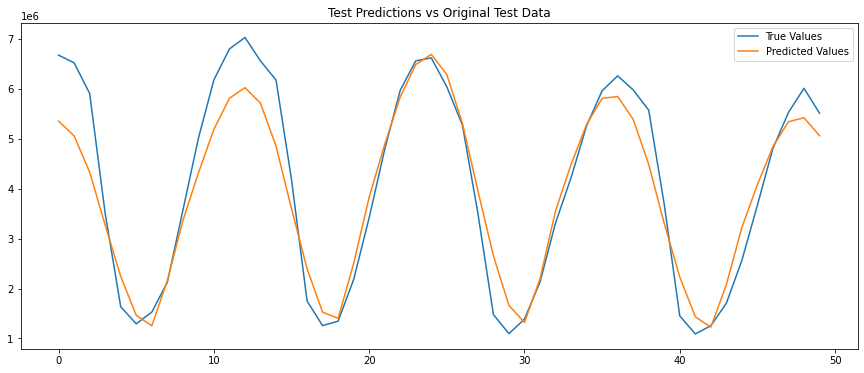

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

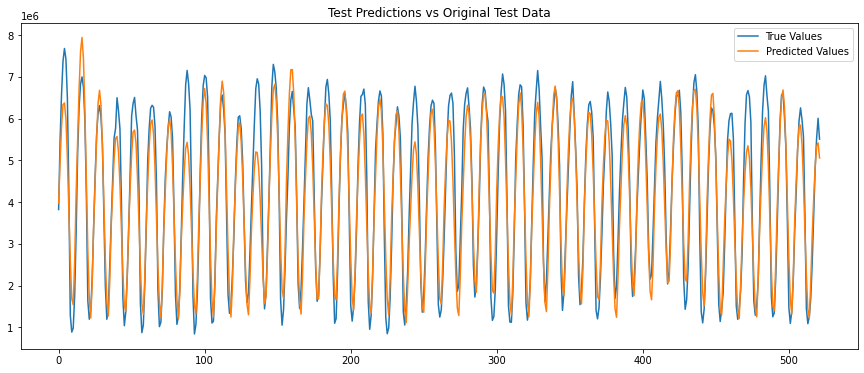

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()